# Inferential statistics II - Bootstrapping

## Introduction

In the previous frequentist mini-projects, you did frequentist calculations to perform inference from a sample of data. Such inference relies on theory largely developed from the 19th-Century onwards that is subject to certain assumptions or theoretical limits. These are fine if those assumptions hold for the particular case you're working on, and what you want to do has a known theoretical distribution (for example the mean of a sampling distribution that we looked at in the previous mini-project.)

In this mini-project, you'll use the same medical charge data you used in the frequentist inference mini-project, but this time you'll make inferences about the population using bootstrapping (ie. simulating repeated re-runs of an experiment.) If frequentism is about using assumptions and theoretical results to calculate what we expect to happen were an experiment to be run again and again and again, then bootstrapping is about using computing power to essentially re-run the sample draw again and again and again to see what actually happens.

## Prerequisites

While these exercises do not strictly depend on these concepts, we encourage you to complete the previous mini-projects before starting this one so that you can approach this assignment with a good understanding of frequentist concepts like:
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate confidence intervals and p-values
* how those confidence intervals and p-values allow you to perform hypothesis (or A/B) tests

To complete mini-project, it's important that you first complete the bootstrap resources listed in this subunit, as they contain valuable information about how to calculate bootstrap replicates of summary statistics. Having an basic understanding of what confidence intervals and p-values are will also be helpful (we touch on them in this mini-project, but please speak to your mentor or conduct individual research if you'd like to learn more.) 

In [24]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

## Medical charge data set

In [25]:
med_charges = pd.read_csv('data/insurance2.csv')

In [26]:
med_charges.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In the previous assignment, you used the frequentist approach to estimate the lower limit for the 95% confidence interval on the mean hospital charge. This approach relies on statistical theory that has been developed over the years and is also limited to statistics for which theoretical results on the sampling distribution exist. These results are remarkably useful and applicable much of the time and under a surprisingly wide range of conditions.

Having calculated the 95% lower confidence interval using frequentist theory in the previous exercise, you'll now use bootstrap inference to verify your calculations and check that you get consistent results without making the assumptions required before. After all, the distribution of charges really was very non-normal.

__Q:__ Use bootstrap sampling to estimate the same 95% confidence interval lower limit as before.

__A:__

In [39]:
N_rep = 10000
np.random.seed(47)

def bootstrap_replicate(data, func):
    """ return the results of func 
        applied to a random sample with replacement 
        from data
    """

    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)
    
def draw_bs_reps(data, func, size):
    """ return an array with len = size
        and entries = the result of 
        applying func to a bootstrapped sample of data
    """
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate(data, np.mean)
    return bs_replicates

bs_mean_charges = draw_bs_reps(med_charges.charges, np.mean, N_rep)
CI = np.percentile(bs_mean_charges, [2.5, 97.5])
print('95% confidence interval lower limit ', CI[0])


95% confidence interval lower limit  12624.862119128531


Note: Performing 10,000 replicates immediately after setting the random seed to 47 returned a lower limit value of 12624. I've been unable to figure out why this lower limit differs from the expected result by 100.
Moving the call to the line above the for loop did not change the outcome, and tncreasing the repetitions to 1,000,000 resulted in a value of 12628, still not the expected result. I am thinking the 0.8% difference with 10,000 replicates is due to rounding and would welcome a correction otherwise.


If you performed 10000 replicates immediately after setting the random seed to 47, you should get the value 12724 here, which compares very well with the value 12725 obtained using the _t_-distribution confidence interval previously. It is a most pleasant result to see the predictions of classical frequentist theory match with results that are now possible through the number-crunching ability of computers.

Remember, in the previous mini-projects, we saw that there are two ways of performing a _t_-test from a sample, depending on whether we can assume the groups have equal variance or not. We can actually easily test this using the bootstrap approach!

__Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates. Plot the histogram of values and mark the locations of the percentiles. State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.

__A:__  The null hypothesis is that the standard deviation in the distribution of insurance claim charges is the same as that of non-insurance claim charges. The alternative hypothesis is that the standard deviation is different between these groups.

95% confidence interval 6468.862868976281 - 8732.67778286385


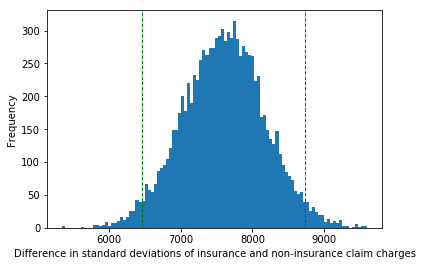

In [30]:
N_rep = 10000
bs_std_ins = draw_bs_reps(med_charges[med_charges.insuranceclaim == 1].charges, np.std, N_rep)
bs_std_no_ins = draw_bs_reps(med_charges[med_charges.insuranceclaim == 0].charges, np.std, N_rep)
bs_diff_std = bs_std_ins - bs_std_no_ins

plt.hist(bs_diff_std, bins=int(np.sqrt(len(bs_diff_std))))
plt.xlabel('Difference in standard deviations of insurance and non-insurance claim charges')
plt.ylabel('Frequency')
CI = np.percentile(bs_diff_std, [2.5, 97.5])
print('95% confidence interval {} - {}'.format(CI[0], CI[1]))
plt.axvline(CI[0], color='green', linestyle='dashed', linewidth=1)
plt.axvline(CI[1], color='green', linestyle='dashed', linewidth=1)
plt.show()

__A:__  The null hypothesis is that the standard deviation in the distribution of insurance claim charges is the same as that of in non-insurance claim charges, ie the difference in the standard deviations of both groups would be zero. The histogram of bootstrapped samples shows that is not the case, with 95% of the differences in standard deviations all greater than zero, and between 6,493 and 8,704. In order to know if this difference is statistically significant and not due to random chance, we should compute a p-value in order to claim we can reject the null hypothesis.

## Confidence interval and p-value

The confidence interval above is often a useful quantity to estimate. If we wish to limit our expected probability of making a Type I error (where we wrongly reject the null hypothesis, and it is, instead, true) to $\alpha$, the associated confidence interval is our estimate of the interval within which we expect the true population value to be found $100\times(1 - \alpha)$% of the time we do this test. In the above we performed bootstrap replicates to estimate the interval and reject the null hypothesis if this interval did not contain zero. You will sometimes see such an interval reported in the output of statistical functions.

The partner of the confidence interval is the p-value. The p-value and the confidence interval are linked through our choice of $\alpha$. The p-value tells us how likely it is, under the null hypothesis, to get an outcome at least as extreme as what was observed. If this fails to reach the level of our _pre-specified_ $\alpha$, we decide the null hypothesis is sufficiently unlikely to be true and thus reject it. To calculate this p-value via the bootstrap, we have to put ourselves in a position where we are simulating the null hypothesis being true and then calculate the fraction of times we observe a result at least as extreme as that actually observed.

Remember how, previously, you used the _t_-test to calculate the p-value for the observed difference between the means of insured and non-insured medical cases. We're now going to repeat this, this time using the bootstrap approach.

__Q:__ Perform a bootstrapped hypothesis test at the 5% significance level ($\alpha = 0.05$) to calculate the p-value of the observed difference between insurance and non-insurance charges, state your null and alternative hypotheses and whether you retain or reject the null hypothesis for the given significance level.

__A:__  The null hypothesis is that people with insurance are charged the same amount as those without insurance. The alternative hypothesis is that people with insurance are charged a different amount as those without insurance.

In [31]:
# Hypothesis testing performed by making means equal in insured and non-insured groups

mean_all_claims = np.mean(med_charges.charges)
ins_charges = med_charges[med_charges.insuranceclaim == 1].charges
no_ins_charges = med_charges[med_charges.insuranceclaim == 0].charges

# to simulate the null hypothesis that the means are equal, shift the means of the insured and 
# non-insured groups to have the same mean as the all_claims mean
ins_shifted = ins_charges - np.mean(ins_charges) + mean_all_claims
no_ins_shifted = no_ins_charges - np.mean(no_ins_charges) + mean_all_claims

# Compute bootstrap replicates from shifted arrays
bs_mean_ins = draw_bs_reps(ins_shifted, np.mean, N_rep)
bs_mean_no_ins = draw_bs_reps(no_ins_shifted, np.mean, N_rep)

# calculate the difference in bootstrapped means
bs_mean_diff = bs_mean_ins - bs_mean_no_ins

# calculate the difference in empirical means
emp_mean_ins = np.mean(med_charges[med_charges.insuranceclaim == 1].charges)
emp_mean_no_ins = np.mean(med_charges[med_charges.insuranceclaim == 0].charges)
emp_mean_diff = emp_mean_ins - emp_mean_no_ins

# determine the portion of difference in bootstrapped means that are 
# at least as extreme as the difference in empirical means
p = np.sum(bs_mean_diff >= emp_mean_diff) / len(bs_mean_diff)
print('p-value = {0:0.4f}'.format(p))


p-value = 0.0000


While the computed p value to 4 decimal places is 0, and there were no bootstrapped differences in means at least as extreme as the empirical difference in means, this does not mean that the p-value is exactly zero, but is actually a very, very small number. This means it is highly unlikely that the empirical difference in means was due to chance, as it is highly unlikely to obtain a difference in means of that size or greater if the means between the insured and non-insured groups were the same. 

With our alpha level at 0.05 and a p-value less than that, we can say that the data are statistically significantly different than we would see under the null hypothesis, and we can reject the null hypothesis that that people with insurance are charged the same amount as those without insurance.  This very small p-value also means there is a very small probability of making a Type I error, so we can reject the null hypothesis with more confidence.

__Q:__ To put the above result in perspective, plot the histogram of your bootstrapped differences along with lines marking the locations of the observed difference. (Why would we plot more than one line, given that we only have one observed difference?)

95% confidence interval -1113.4333991264286  1115.8230185133536


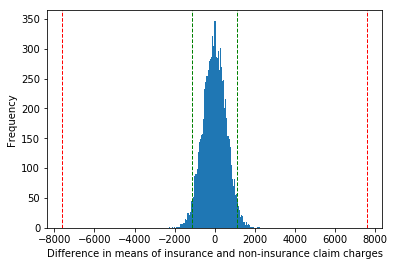

In [32]:
plt.hist(bs_mean_diff, bins=int(np.sqrt(len(bs_mean_diff))))
plt.xlabel('Difference in means of insurance and non-insurance claim charges')
plt.ylabel('Frequency')
CI = np.percentile(bs_mean_diff, [2.5, 97.5])
print('95% confidence interval {}  {}'.format(CI[0], CI[1]))
plt.axvline(CI[0], color='green', linestyle='dashed', linewidth=1)
plt.axvline(CI[1], color='green', linestyle='dashed', linewidth=1)
plt.axvline(emp_mean_diff, color='red', linestyle='dashed', linewidth=1)
plt.axvline(-empirical_diff_means, color='red', linestyle='dashed', linewidth=1)
plt.show()

__A:__  There are multiple lines for the observed difference because as with the simulated data, the observed difference could be positive or negative, depending on how it is calculated.

__Q:__ Compare your p-value above with that obtained using the _t_-test function in the previous assignment. Do you think you would want to try to perform enough bootstrap replicates to observe a random difference as large as that we did observe?

__A:__  With a p-value of 4.461230231620717e-31 obtained using the t-test, and with 1 million replicates still returning a p-value of zero, it would not seem reasonable to attempt to perform enough bootstrap replicates to observe that large of a difference.

__Q:__ Consider the two variants of the _t_-test we performed in the previous assignment. Which one would you use now?

__A:__   After rejecting the null hypothesis that the variance was equal in the insured and non-insured groups, the version of the t-test that accounts for non-equal variances should be used. 

__Q:__ If, instead of being asked whether the means of two groups were different, you were working with an ad-recommender team who wanted to release a new recommendation algorithm, and you were looking at click-through rate both for the current algorithm (call it A) and from trials of their new algorithm (call it B), would you perform a two-sided test as above? What would be your null and alternative hypotheses and what would be the real-world consequence of rejecting the null hypothesis?

__A:__  A one-sided test should be performed, to see if the click-through rate of algorithm B was more than the click-through rate of algorithm A.  

The null hypothesis would be that the click-through rate of B = A.  The alternative hypothesis would be that the click-through rate of B <> A.

The real-world consequence of rejecting the null hypothesis would be to improve the click-through rate by adopting algorithm B.

# Learning outcomes

You've previously applied frequentist methods to calculate confidence intervals, p-values, and perform hypothesis tests. Frequentist methods use theoretical results to calculate what we expect would happen if experiments were to be run again and again and again. Now you've seen how you can do the same things using the bootstrap approach, which does not rely on such theory, and attendant assumptions, but instead literally does run experiments again and again and again.

In these exercises, you have:
* calculated the same confidence interval lower limit as you did previously
* tested the assumption that the variances of the two groups (insured vs. non-insured) were equal - something a bit harder to do using the frequentist method because of the nature of the sampling distribution for variance
* calculated the p-value for the difference between the means of the two groups and compared with the result obtained using the previous frequentist approach

You are now well equipped to apply the bootstrap approach to a wide variety of problems. Just think about what conditions you wish to recreate in your simulated reruns.